# Semantic Image Segmentation on CityScapes Dataset using U-Net Archtitecture

##### *Luciano Deben   1440705*
---

## Import Libraries

In [1]:
# Importing the libraries        
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys
sys.path.append("..")

from model import Model
from process_data import get_data_loader
from process_data import preprocess, preprocess_mask, joint_preprocess
from config import config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ldeben20 (luciano-deben). Use `wandb login --relogin` to force relogin


In [2]:
# Global variables
DATA_PATH = "../data/CityScapes/"

class Args:
    def __init__(self):
        self.data_path = DATA_PATH
    
args = Args()

## Data Preprocessing

In [3]:
# Instantiate the data loaders
train_loader, val_loader = get_data_loader(args, config.batch_size, config.num_workers)

In [4]:
# Get a batch of training and validation data
inputs, targets = next(iter(train_loader))
val_inputs, val_targets = next(iter(val_loader))

torch.Size([3, 520, 1040]) torch.Size([1, 520, 1040])


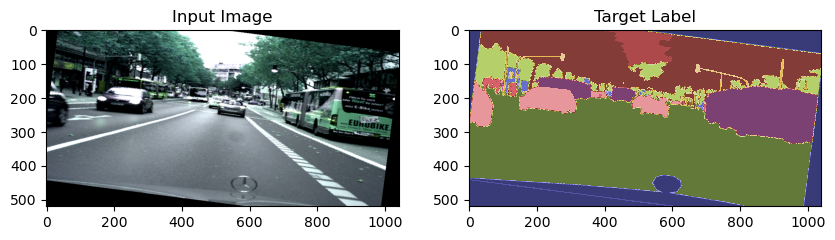

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)


In [5]:
# Check the size of the data
exp_input = inputs[0]
exp_target = targets[0]
print(exp_input.size(), exp_target.size())

# Normalize the image to the range [0, 1]
exp_input_normalized = (exp_input - exp_input.min()) / (exp_input.max() - exp_input.min())

# Plot the examples
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(exp_input_normalized.permute(1, 2, 0))
plt.title("Input Image")
plt.subplot(1, 2, 2)
plt.imshow(exp_target.squeeze(), cmap='tab20b')
plt.title("Target Label")
plt.show()

print(exp_target)

In [6]:
print(exp_target.unique())

# exp_input = preprocess(exp_input)
# exp_target_2 = preprocess_mask(exp_target)

print(exp_input.size(), exp_target.dtype)
print(exp_target.unique())
print(exp_input.min(), exp_input.max())

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33],
       dtype=torch.uint8)
torch.Size([3, 520, 1040]) torch.uint8
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33],
       dtype=torch.uint8)
tensor(-1.) tensor(1.)


## Model Training

In [7]:
from torchvision.models.segmentation import DeepLabV3_ResNet101_Weights

weights = DeepLabV3_ResNet101_Weights.DEFAULT
transforms = weights.transforms(resize_size=None)

print(exp_input.size(), exp_target.size())

exp_input_t = transforms(exp_input)
print(exp_input_t.size())

torch.Size([3, 520, 1040]) torch.Size([1, 520, 1040])
torch.Size([3, 520, 1040])


In [8]:
model = Model()

In [9]:
model_size = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [10]:
# Assuming inputs is a sample from your dataset
input_size = exp_input.element_size() * exp_input.nelement()  # Size in bytes
input_size /= 1024 ** 2  # Size in MB
print(f"Input size: {input_size} MB")

Input size: 6.18896484375 MB


In [11]:
vram_usage = model_size + (input_size * 32)
vram_usage /= 1024 ** 2  # Convert to MiB
print(f"Model VRAM Usage: {vram_usage:.2f} MiB")

Model VRAM Usage: 58.17 MiB
